# HealthCare Costs Analysis

By Lingxiao He

---

The dataset I obtained examines the cost of healthcare for a sample of individuals, taking into account factors such as their smoking habits, age, gender, body mass index, and region. My goal is to perform data profiling analysis of the data, using statistical values and machine learning algorithms to provide both prescriptive and quantitative insights. 

To achieve this, I built a variety of regression models to identify the best estimator for insurance charges, and also developed different classification models to predict the smoking status of patients.

---

### Acknowledgements
Data imported from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Visit their page for publicly available datasets to practice with ML and creating pipelines.

In [111]:
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

df = pd.read_csv('insurance.csv') # import the CSV as a pandas dataframe


In [112]:
random.seed(10)

random_list = random.sample(range(df.shape[0]), round(float(df.shape[0])*0.05))
df_new = df.copy()
df_new.loc[random_list,"bmi"] = None

# check for missing values
missing_values = df_new.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0]/df_new.shape[0] # normalize
print(f'{missing_values *100} %')

bmi    5.007474
dtype: float64 %


Deal with missing values

In [113]:
def proximityMatrix(model, X, normalize=True):      

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    if normalize:
        proxMat = proxMat / nTrees

    return proxMat   

from sklearn.ensemble import  RandomForestClassifier

In [121]:
df_missing = df_new.loc[df_new.bmi.isnull(),]
df_missing.loc[df_missing.smoker=="yes","bmi"] = df_new.loc[(df_new.bmi.notnull())&(df_new.smoker=="yes"),"bmi"].mean()

df_missing.loc[df_missing.smoker=="no","bmi"] = df_new.loc[(df_new.bmi.notnull())&(df_new.smoker=="no"),"bmi"].mean()

df_not_missing = df_new.loc[df_new.bmi.notnull(),]

In [122]:
df_train = pd.concat([df_not_missing, df_missing], axis = 0)

df_Y = df_train.loc[:,"smoker"]
df_X = df_train.loc[:,df_train.columns != "smoker"]
df_X = pd.get_dummies(df_X)

In [123]:
i = 0
for i in range(3):
    model = RandomForestClassifier(n_estimators=500, max_features=3, min_samples_leaf=40)
    model.fit(df_X, df_Y)
    matrix = proximityMatrix(model, df_X, normalize=True)

    s = []
    for i in range(matrix.shape[0]):
        s.append((sum(pd.Series(matrix[i])*df_X.bmi)-matrix[i][i])/(matrix[i].sum()-1))

    df_X.loc[:, "forcast_bmi"] = s

    df_X.loc[random_list, "bmi"] = df_X.loc[random_list, "forcast_bmi"] 
    df_X.drop("forcast_bmi", axis = 1, inplace = True)
    i += 1

Using the converted dataset, we can visualize the correlation heatmap

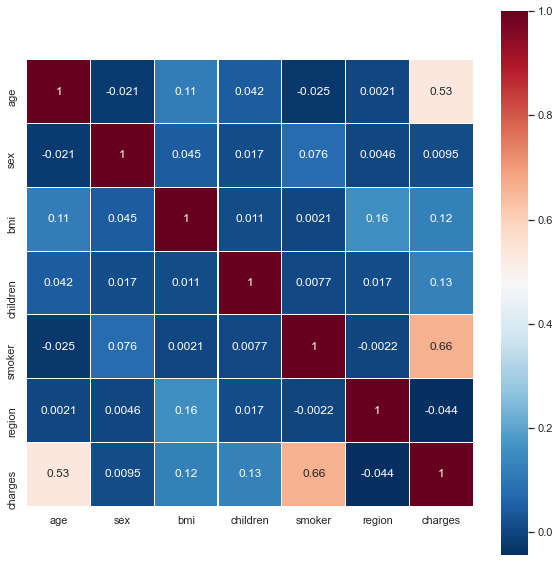

In [180]:
from sklearn.preprocessing import LabelEncoder


# df_label_corr = df_label.copy()
# for i in range(len(df_label.columns)):
#     j = i+1
#     for j in range(j,len(df_label.columns)-1):
#         df_label_corr.loc[:, "{}*{}".format(df_label.columns[i],df_label.columns[j])] = df_label.loc[:,df_label.columns[i]]*df_label.loc[:,df_label.columns[j]]
#         print("{}*{}".format(df_label.columns[i],df_label.columns[j]))
# df_label.columns[0]
# sns.set(color_codes=True)
# plt.figure(figsize=(14, 12))
# sns.heatmap(df_label_corr.astype(float).corr(), 
#             linewidths=0.2, 
#             square=True, 
#             linecolor='white', 
#             annot=True,
#             cmap="RdBu_r")
# plt.show()

# convert str values to int using the scikit-learn encoder
df_label = df.apply(LabelEncoder().fit_transform)

sns.set(color_codes=True)
plt.figure(figsize=(10, 10))
sns.heatmap(df_label.astype(float).corr(), 
            linewidths=0.2, 
            square=True, 
            linecolor='white', 
            annot=True,
            cmap="RdBu_r")
plt.show()

Seems like age and smoking weigh the most when looking at the charges row (or column). We expect the weights of these two to be higher than the rest.   

In [134]:
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df.loc[:,"smoker"],
    histnorm='percent',
    name='smoking status', # name used in legend and hover labels
    marker_color=['#330C73','#EB89B5'],
    opacity=0.6
))
fig.update_layout(
    title_text='Smoking status', # title of plot
    xaxis_title_text='', # xaxis label
    yaxis_title_text='Percentage', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    width=700, height=500
)
fig.show()

In [139]:
df_plot = df.copy()

labels_charge = ["{}-{}K".format(i*4, (i+1)*4) for i in range(0,20)]
bins_charge = [i*4000 for i in range(0,21)]

labels_age = ['18-29', '30-39', '40-49', '50-59', '60-69', '70+']
bins_age = [18, 30, 40, 50, 60, 70, 80]

df_plot['age_range'] = pd.cut(df_plot.age, bins_age, labels = labels_age,include_lowest = True)

df_plot['charge_range'] = pd.cut(df_plot.charges, bins_charge, labels = labels_charge, include_lowest = True)

In [140]:
#### Age VS Sex
df_population = pd.DataFrame({
    "age_range":["<20", "20-24" ,"25-29", "30-34","35-39","40-44","45-49","50-54","55-59","60-64",">65"],
    "age":[20, 22 ,28, 32,38,42,48,52,58,62,65],
    "percentage":[25.0,6.5,7.1,6.8,6.6,6.1,6.0,6.1,6.5,6.5,16.8]
})

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df.loc[df.sex=="female","age"],
    histnorm='percent',
    name='Female', # name used in legend and hover labels
    marker_color='#EB89B5',
    opacity=0.6
))
fig.add_trace(go.Histogram(
    x=df.loc[df.sex=="male","age"],
    histnorm='percent',
    name='Male',
    marker_color='#330C73',
    opacity=0.6
))
fig.add_trace(go.Scatter(x=df_population.age, y=df_population.percentage,
                    mode='lines+markers',
                    name='US population by age',
                    marker_color="red"))

fig.update_layout(
    title_text='Population distribution by sex and age', # title of plot
    xaxis_title_text='Age', # xaxis label
    yaxis_title_text='Percentage', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    width=900, height=500
)

fig.show()

Smoker Distribution Over Age

In [145]:
#### Smoker Distribution Over Age

df_plot_temp1 = pd.concat([df_plot["age_range"], pd.get_dummies(df_plot["smoker"])], axis = 1)
    
df_plot_age_grouped = df_plot_temp1.groupby('age_range').agg({"yes":"sum", "no":"sum"})

df_plot_age_grouped = df_plot_age_grouped.reset_index()

df_plot_age_grouped["Yes %"] = df_plot_age_grouped.apply(lambda x: round(x.yes/(x.yes+x.no)*100,1) if (x.yes+x.no)>0 else 0, axis = 1)
df_plot_age_grouped["No %"] = df_plot_age_grouped.apply(lambda x: round(x.no/(x.yes+x.no)*100,1) if (x.yes+x.no)>0 else 0, axis = 1)


fig = px.bar(df_plot_age_grouped, x = "age_range", y = ["yes", "no"], hover_data=['Yes %', 'No %'], text_auto='.s',
             color_discrete_map={'yes': '#330C73', 'no': '#EB89B5'},
             labels = {"yes":"Yes", "no":"No"},
              title ="Smoker distribution by age groups", opacity=0.6)

fig.update_layout(width=700, height=500, xaxis_title_text='Age Range', yaxis_title_text='Value Count')
fig.show()

In [147]:
#### Chargers VS Smoker
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df.loc[df.smoker=="yes","charges"],
    histnorm='percent',
    name='Smoker', # name used in legend and hover labels
    marker_color='#330C73',
    opacity=0.6
))
fig.add_trace(go.Histogram(
    x=df.loc[df.smoker=="no","charges"],
    histnorm='percent',
    name='Non smoker',
    marker_color='#EB89B5',
    opacity=0.6
))

fig.update_layout(
    width=700, height=500,
    title_text='Medical charges distribution by smoking status', # title of plot
    xaxis_title_text='Charges', # xaxis label
    yaxis_title_text='Percentage', # yaxis label
    bargap=0.1, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

In [154]:
round(df_plot.groupby("smoker")["charges"].describe(),1)

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
no,1064.0,8434.3,5993.8,1121.9,3986.4,7345.4,11362.9,36910.6
yes,274.0,32050.2,11541.5,12829.5,20826.2,34456.3,41019.2,63770.4


In [88]:
#### BMI VS Age
fig = go.Figure()

for age_range in df_plot.age_range.unique():
    fig.add_trace(go.Histogram(
        x=df_plot.loc[df_plot.age_range==age_range,"bmi"],
        histnorm='',
        name=age_range, # name used in legend and hover labels
        opacity=0.6
    ))

fig.update_layout(width=700, height=500, barmode = 'relative', title = 'BMI distribution over different age groups', 
          yaxis = dict(title = 'Value Count', automargin = True),
          xaxis = dict(title = 'BMI', automargin = True))
fig.update_xaxes(categoryarray=labels_charge)

fig.show()

In [108]:
df_plot.groupby("age_range")["bmi"].describe()

,count,mean,std,min,25%,50%,75%,max
age_range,,,,,,,,
18-29,444.0,29.890766,6.247665,15.960,25.460,29.815,33.770,53.13
30-39,257.0,30.399864,6.174990,16.815,26.400,29.800,34.320,47.60
40-49,281.0,30.808078,5.756009,19.190,26.600,30.300,34.580,48.07
50-59,265.0,31.449377,6.081155,18.050,26.700,31.600,35.900,49.06
60-69,91.0,32.441813,5.663759,21.090,28.255,32.680,36.855,44.00
70+,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


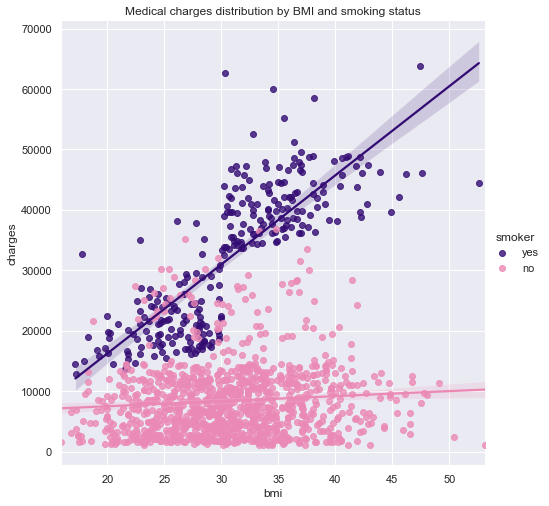

In [152]:
#### BMI VS Age
sns.lmplot(x="bmi", y="charges", hue="smoker", data=df, palette=dict(yes="#330C73", no="#EB89B5"), size = 7)\
.set(title="Medical charges distribution by BMI and smoking status") 

plt.show()

In [148]:
#### Charges VS Age
fig = go.Figure()

for age_range in df_plot.age_range.unique():
    fig.add_trace(go.Histogram(
        x=df_plot.loc[df_plot.age_range==age_range,"charge_range"],
        histnorm='',
        name=age_range, # name used in legend and hover labels
        opacity=0.6
    ))

fig.update_layout(width=700, height=500, barmode = 'stack', title = 'Medical charges over different age groups', 
          yaxis = dict(title = 'Value Count', automargin = True),
          xaxis = dict(title = 'Charge Range', automargin = True))
fig.update_xaxes(categoryarray=labels_charge)

fig.show()

In [149]:
#### Smoker Charges VS Age
fig = go.Figure()

for age_range in df_plot.age_range.unique():
    fig.add_trace(go.Histogram(
        x=df_plot.loc[(df_plot.smoker=="yes")&(df_plot.age_range==age_range),"charge_range"],
        histnorm='',
        name=age_range, # name used in legend and hover labels
        opacity=0.6
    ))

fig.update_layout(width=700, height=500, barmode = 'stack', title = 'Medical charges for smokers over different age groups', 
          yaxis = dict(title = 'Value Count', automargin = True),
          xaxis = dict(title = 'Charge Range', automargin = True))
fig.update_xaxes(categoryarray=labels_charge)

fig.show()

In [150]:
#### Non Smoker Charges VS Age
fig = go.Figure()

for age_range in df_plot.age_range.unique():
    fig.add_trace(go.Histogram(
        x=df_plot.loc[(df_plot.smoker=="no")&(df_plot.age_range==age_range),"charge_range"],
        histnorm='',
        name=age_range, # name used in legend and hover labels
        opacity=0.6
    ))

fig.update_layout(width=700, height=500, barmode = 'stack', title = 'Medical charges for non smokers over different age groups', 
          yaxis = dict(title = 'Value Count', automargin = True),
          xaxis = dict(title = 'Charge Range', automargin = True))
fig.update_xaxes(categoryarray=labels_charge)

fig.show()

Judging by the party life at UVa, we can see why so many young adults even seek medical care.

In [90]:
#### Smoker VS Sex
fig = go.Figure()


fig.add_trace(go.Histogram(
    x=df.loc[df.smoker=="yes","sex"],
    histnorm='percent',
    name='Smoker', # name used in legend and hover labels
    marker_color='#330C73',
    opacity=0.6
))
fig.add_trace(go.Histogram(
    x=df.loc[df.smoker=="no","sex"],
    histnorm='percent',
    name='Non smoker',
    marker_color='#EB89B5',
    opacity=0.6
))

fig.update_layout(
    width=700, height=500,
    title_text='Smoking status by sex', # title of plot
    xaxis_title_text='Sex', # xaxis label
    yaxis_title_text='Percentage', # yaxis label
#     bargap=0.1, # gap between bars of adjacent location coordinates
#     bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show()

Luckily, the majority understands the downsides of smoking.

The data seems pretty balanced with a slight skew towards male.

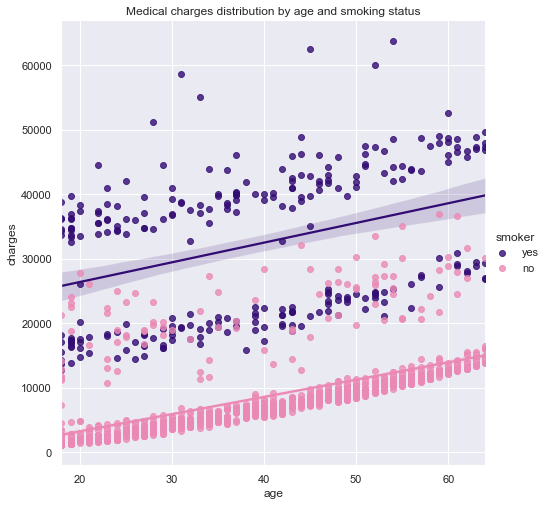

In [151]:
sns.lmplot(x="age", y="charges", hue="smoker", data=df, palette=dict(yes="#330C73", no="#EB89B5"), size = 7)\
.set(title="Medical charges distribution by age and smoking status") 
# sns.set_title('Smokers and non-smokers');
plt.show()

While it seems obvious that the charges increase linearly with age, smoking appears to be the highest contributor to charges.

[Text(0.5, 1.0, 'T-SNE projection')]

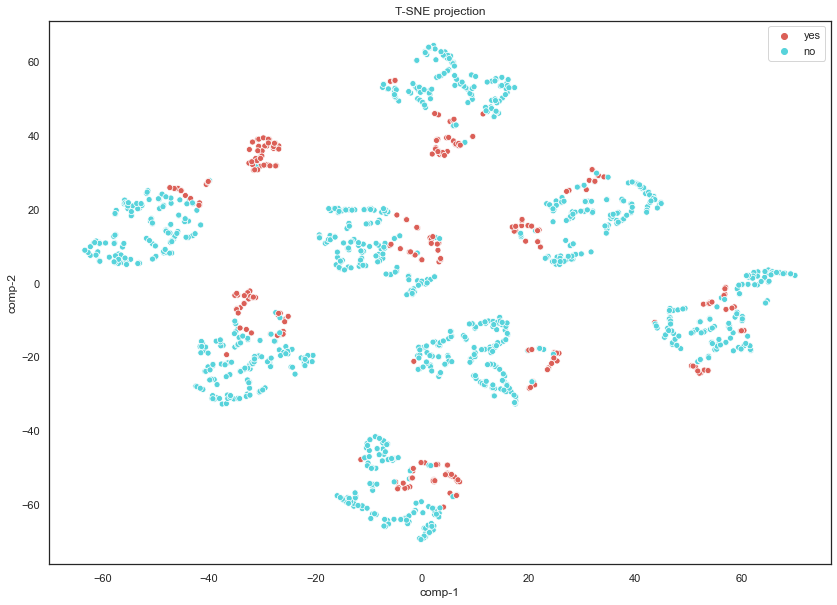

In [84]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

data = pd.get_dummies(df.drop("smoker", axis=1)).values
# scaled_data = StandardScaler().fit_transform(data)
tsne = TSNE(n_components=2, perplexity=14, verbose=0, n_iter=2000, learning_rate = 5, random_state=123)

z = tsne.fit_transform(scaled_data) 
df_tsne = pd.DataFrame()
df_tsne["category"] = df.smoker
df_tsne["comp-1"] = z[:,0]
df_tsne["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_tsne.category.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df_tsne).set(title="T-SNE projection") 

### Regression models to predict medical costs

First step is to apply get dummies which works like this: 

The `pandas.get_dummies` converts the vectors of categorical features into a vector-matrix multiplication with a boolean matrix of ones and zeros. This will be more useful since our regressor will treat the inputs as numbers instead of integers.

Here is an example of how it works:

$\vec{b}=\beta \vec{x}$

Observe how the dummies matrix is represented for the smoker categorical feature:

$$\begin{pmatrix}\text{smoker_yes}\\ \text{smoker_no}\\ \text{smoker_no}\\ \vdots  \end{pmatrix}=\begin{bmatrix}
    1 & 0 \\
    0 & 1\\
    0 & 1\\
    \vdots & \vdots \\
    \end{bmatrix} \; 
    \begin{pmatrix}\text{smoker_yes} \\  \text{smoker_no} \\ \end{pmatrix}$$

In [155]:
df_model = df.copy()
df_model['age'] = df_model['age'].astype(float)
df_model['children'] = df_model['children'].astype(float)

df_model = pd.get_dummies(df_model)

## Split the data
df_Y = df_model['charges']
df_X = df_model.drop(columns=['charges'])

Since no testing data is provided, we will split the given dataset into training and testing sets.

### Linear Regression (before feature engineering)

In [156]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# use 20% of dataset as testing data

X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42)

lr = LinearRegression().fit(X_train, Y_train)

lr_train_pred = lr.predict(X_train)
lr_test_pred = lr.predict(X_test)

lr_train_mse = mean_squared_error(Y_train, lr_train_pred)
lr_test_mse = mean_squared_error(Y_test, lr_test_pred)

print('MSE train data: {:.5}, MSE test data: {:.5}'.format(lr_train_mse, lr_test_mse))

print('RMSE train data: {:.5}, RMSE test data: {:.5}'.format(
    np.sqrt(np.absolute(lr_train_mse)), 
    np.sqrt(np.absolute(lr_train_mse))))
                                                               
print('R2 train data: {:.5}, R2 test data: {:.5}'.format(
    r2_score(Y_train,lr_train_pred),
    r2_score(Y_test,lr_test_pred)))

MSE train data: 3.7278e+07, MSE test data: 3.3597e+07
RMSE train data: 6105.5, RMSE test data: 6105.5
R2 train data: 0.74173, R2 test data: 0.78359


In [162]:
from sklearn.model_selection import cross_val_score
lr_cv = cross_val_score(LinearRegression(), df_X, df_Y, cv = 10)
# accuracy +/- 2 standard deviations
print("Accuracy: {:.2} (+/- {:.2})".format(lr_cv.mean(), lr_cv.std() * 2)) 

Accuracy: 0.74 (+/- 0.086)


This isn't too bad for a first try. What happens if we implement polynomial features?

Polynomial features works on adding a matrix of polynomial coefficients of up to the $k^{th}$ order, generated by non-linear relationships of current features.

For the case of $k=2$ it looks something like this:

$$A\cdot(x_1+x_2+..+x_n)^2 = a_1 x_1^2+a_2 x_1 x_2 + a_3 x_2^2+a_4 x_2 x_3+..$$

Where $a_i$ represents the coefficient for Linear Regression to manipulate.

This helps us see the effect of non-linear relationships between features.

In [163]:
from sklearn.preprocessing import PolynomialFeatures

X_poly =  PolynomialFeatures(degree = 2).fit_transform(df_X)

interaction_columns = PolynomialFeatures(degree = 2).fit(df_X).get_feature_names(df_X.columns)


X_train, X_test, Y_train, Y_test = train_test_split(X_poly, df_Y, test_size=0.2, random_state=42)


pr = LinearRegression().fit(X_train, Y_train)

pr_train_pred = pr.predict(X_train)
pr_test_pred = pr.predict(X_test)

pr_train_mse = mean_squared_error(Y_train,pr_train_pred)
pr_test_mse = mean_squared_error(Y_test,pr_test_pred)


print('MSE train data: {:.5}, MSE test data: {}'.format(pr_train_mse, pr_test_mse))

print('RMSE train data: {:.5}, RMSE test data: {:.5}'.format(
    np.sqrt(np.absolute(pr_train_mse)), 
    np.sqrt(np.absolute(pr_train_mse))))
                                                               
print('R2 train data: {:.5}, R2 test data: {:.5}'.format(
    r2_score(Y_train,pr_train_pred),
    r2_score(Y_test,pr_test_pred)))

MSE train data: 2.2877e+07, MSE test data: 20792160.984921366
RMSE train data: 4782.9, RMSE test data: 4782.9
R2 train data: 0.8415, R2 test data: 0.86607


In [164]:
pr_cv = cross_val_score(LinearRegression(), X_poly, df_Y, cv = 10)
# accuracy +/- 2 standard deviations
print("Accuracy: {:.2} (+/- {:.2})".format(pr_cv.mean(), pr_cv.std() * 2)) 

Accuracy: 0.76 (+/- 0.19)


Splendid! Now we have a better variance score using polynomial relationships.

### Random Forest Model

In [165]:
from sklearn.ensemble import RandomForestRegressor


rfr = RandomForestRegressor(n_estimators = 500, bootstrap = True, oob_score = True, 
                            max_features = "sqrt", max_depth=6).fit(X_train, Y_train)
rfr_train_pred = rfr.predict(X_train)
rfr_test_pred = rfr.predict(X_test)


rfr_train_mse = mean_squared_error(Y_train,rfr_train_pred)
rfr_test_mse = mean_squared_error(Y_test,rfr_test_pred)


print('MSE train data: {:.5}, MSE test data: {:.5}'.format(rfr_train_mse, rfr_test_mse))

print('RMSE train data: {:.5}, RMSE test data: {:.5}'.format(
    np.sqrt(np.absolute(rfr_train_mse)), 
    np.sqrt(np.absolute(rfr_train_mse))))
                                                               
print('R2 train data: {:.5}, R2 test data: {:.5}'.format(
    r2_score(Y_train, rfr_train_pred),
    r2_score(Y_test, rfr_test_pred)))

MSE train data: 1.5402e+07, MSE test data: 1.9426e+07
RMSE train data: 3924.5, RMSE test data: 3924.5
R2 train data: 0.89329, R2 test data: 0.87487


In [166]:
rfr_cv = cross_val_score(RandomForestRegressor(n_estimators = 500), X_poly, df_Y, cv = 10)
# accuracy +/- 2 standard deviations
print("Accuracy: {:.2} (+/- {:.2})".format(rfr_cv.mean(), rfr_cv.std() * 2)) 

Accuracy: 0.83 (+/- 0.095)


### Bayesian Ridge Model

In [167]:
from sklearn.linear_model import BayesianRidge

br = BayesianRidge().fit(X_train, Y_train)

br_train_pred = br.predict(X_train)
br_test_pred = br.predict(X_test)


br_train_mse = mean_squared_error(Y_train, br_train_pred)
br_test_mse = mean_squared_error(Y_test, br_test_pred)


print('MSE train data: {:.5}, MSE test data: {:.5}'.format(br_train_mse, br_test_mse))

print('RMSE train data: {:.5}, RMSE test data: {:.5}'.format(
    np.sqrt(np.absolute(br_train_mse)), 
    np.sqrt(np.absolute(br_train_mse))))
                                                               
print('R2 train data: {:.5}, R2 test data: {:.5}'.format(
    r2_score(Y_train, br_train_pred),
    r2_score(Y_test, br_test_pred)))

MSE train data: 2.4834e+07, MSE test data: 2.159e+07
RMSE train data: 4983.4, RMSE test data: 4983.4
R2 train data: 0.82794, R2 test data: 0.86093


In [168]:
br_cv = cross_val_score(BayesianRidge(), X_poly, df_Y, cv = 10, scoring='r2')
# accuracy +/- 2 standard deviations
print("Accuracy: {:.2} (+/- {:.2})".format(br_cv.mean(), br_cv.std() * 2)) 

Accuracy: 0.83 (+/- 0.077)


This is a decent prediction, we can safely assume that the Random Forest wins with a variance score of 97% against training data, and 84% against data it has never seen before. It also has the lowest root MSE value.

With cross-validation, however, Bayesian regression gets the same average as the Random Forest but with a smaller standard deviation using 7 folds.

We do not have to worry about overfitting with Random Forest.

### Gradient Boosting for Regression

In [169]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, max_depth=3, max_features="auto", 
                                 random_state=0).fit(X_train, Y_train)

gb_train_pred = gb.predict(X_train)
gb_test_pred = gb.predict(X_test)


gb_train_mse = mean_squared_error(Y_train, gb_train_pred)
gb_test_mse = mean_squared_error(Y_test, gb_test_pred)


print('MSE train data: {:.5}, MSE test data: {:.5}'.format(gb_train_mse, gb_test_mse))

print('RMSE train data: {:.5}, RMSE test data: {:.5}'.format(
    np.sqrt(np.absolute(gb_train_mse)), 
    np.sqrt(np.absolute(gb_train_mse))))
                                                               
print('R2 train data: {:.5}, R2 test data: {:.5}'.format(
    r2_score(Y_train, gb_train_pred),
    r2_score(Y_test, gb_test_pred)))

MSE train data: 1.4999e+07, MSE test data: 1.8674e+07
RMSE train data: 3872.9, RMSE test data: 3872.9
R2 train data: 0.89608, R2 test data: 0.87972


In [170]:
gb_cv = cross_val_score(gb, X_poly, df_Y, cv = 10, scoring='r2')
# accuracy +/- 2 standard deviations
print("Accuracy: {:.2} (+/- {:.2})".format(br_cv.mean(), br_cv.std() * 2)) 

Accuracy: 0.83 (+/- 0.077)


### Feature importance

In [171]:
feature_importance = pd.DataFrame(sorted(zip(gb.feature_importances_,interaction_columns)), columns=['Value','Feature'])


fig = px.bar(feature_importance.sort_values(by="Value", ascending=False).iloc[:10,:], x = "Feature", y = "Value",
             color_discrete_map={"Value":'#330C73'},
              title ="Top 10 Important Features", opacity=0.6)

fig.update_layout(width=700, height=500, xaxis_title_text='Feature', yaxis_title_text='Importance')
fig.show()

## Classification Models to Predict Smoking Status

### Logistic Ression Model

In [172]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

df_X2 = df.drop("smoker", axis = 1)
df_X2 = pd.get_dummies(df_X2)
df_Y2 = df.smoker
df_Y2 = df_Y2.apply(lambda x: 1 if x=="yes" else 0)

X_poly2 =  PolynomialFeatures(degree = 2).fit_transform(df_X2)

interaction_columns2 = PolynomialFeatures(degree = 2).fit(df_X2).get_feature_names(df_X2.columns)


X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_poly2, df_Y2, test_size=0.1, random_state=42)

logistics = LogisticRegression(penalty='l1', C= 0.056842105263157895, solver = "liblinear", max_iter = 500, 
                               verbose = 1, n_jobs=-1, random_state=42).fit(X_train2, Y_train2)

logistics_train_pred = logistics.predict_proba(X_train2)[:, 1]
logistics_train_auc = roc_auc_score(Y_train2, logistics_train_pred)

logistics_test_pred = logistics.predict_proba(X_test2)[:, 1]
logistics_test_auc = roc_auc_score(Y_test2, logistics_test_pred)

print('Train AUC: {:.2}'.format(logistics_train_auc))
print('Test AUC: {:.2}'.format(logistics_test_auc))

[LibLinear]Train AUC: 0.99
Test AUC: 0.99


In [173]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

logistics_train_pred_label = logistics.predict(X_train2)
confusion_matrix(Y_train2, logistics_train_pred_label)

recall_score(Y_train2, logistics_train_pred_label,average="binary")

0.967741935483871

### Gadient Boosting for Classification

In [174]:

from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01, max_depth=3, max_features="auto", 
                                 random_state=0).fit(X_train2, Y_train2)

gb_clf_train_pred = gb_clf.predict_proba(X_train2)[:, 1]
gb_clf_train_auc = roc_auc_score(Y_train2, gb_clf_train_pred)

gb_clf_test_pred = gb_clf.predict_proba(X_test2)[:, 1]
gb_clf_test_auc = roc_auc_score(Y_test2, gb_clf_test_pred)

print('Train AUC: {:.2}'.format(gb_clf_train_auc))
print('Test AUC: {:.2}'.format(gb_clf_test_auc))

Train AUC: 1.0
Test AUC: 0.99


In [175]:
gb_clf_test_pred_label = gb_clf.predict(X_test2)
confusion_matrix(Y_test2, gb_clf_test_pred_label)

recall_score(Y_test2, gb_clf_test_pred_label,average="binary")

1.0

### Feature Importance

In [176]:
feature_importance2 = pd.DataFrame(sorted(zip(gb_clf.feature_importances_,interaction_columns2)), columns=['Value','Feature'])


fig = px.bar(feature_importance2.sort_values(by="Value", ascending=False).iloc[:10,:], x = "Feature", y = "Value",
             color_discrete_map={"Value":'#330C73'},
              title ="Top 10 Important Features", opacity=0.6)

fig.update_layout(width=700, height=500, xaxis_title_text='Feature', yaxis_title_text='Importance')
fig.show()